In [83]:
from datetime import datetime

from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter
from pytket.utils.operators import QubitPauliOperator
from pytket.partition import measurement_reduction, MeasurementBitMap, MeasurementSetup, PauliPartitionStrat
from pytket.backends.backendresult import BackendResult
from pytket.pauli import Pauli, QubitPauliString
from pytket.circuit import Qubit
import pytket.qasm

from scipy.optimize import minimize
from numpy import ndarray
from numpy.random import random_sample
from sympy import Symbol
from functools import partial

import qnexus as qnx
from copy import deepcopy
import matplotlib.pyplot as plt

In [50]:
# qibo's
import qibo
from qibo import gates, hamiltonians, models
from qibo.backends import GlobalBackend
from qibo.models.dbi.double_bracket import (
    DoubleBracketGeneratorType,
    DoubleBracketIteration,
)


# boostvqe's
from boostvqe import ansatze
from boostvqe.plotscripts import plot_gradients, plot_loss
from boostvqe.training_utils import Model, vqe_loss, TLFIM
from boostvqe.models.dbi.double_bracket_evolution_oracles import *
from boostvqe.utils import (
    DBI_D_MATRIX,
    DBI_ENERGIES,
    DBI_FLUCTUATIONS,
    DBI_STEPS,
    FLUCTUATION_FILE,
    GRADS_FILE,
    HAMILTONIAN_FILE,
    LOSS_FILE,
    SEED,
    TOL,
    apply_dbi_steps,
    create_folder,
    generate_path,
    results_dump,
    rotate_h_with_vqe,
    train_vqe,
)
import numpy as np

## Helper functions

In [51]:
# helper functions
def exact_expectation_boost(ham, circ):
    # calculates the exact expectation of hamiltonian given a circuit in qibo
    return ham.expectation(
        ham.backend.execute_circuit(circuit=circ).state())

# TLFIM model

Our goal here is to run VQE on the TFIM model, defined as
$$
H_{TLFIM} = - \sum _{i=0}^N \left ( Z_i Z_{i + 1} + h_0 X_i + h_1 Z_i \right ).
$$

Let's use $L=5$ and $h_0=3, h_1=1$.

In [52]:
qibo.set_backend("tensorflow")

[Qibo 0.2.12|INFO|2024-10-22 12:20:09]: Using tensorflow backend on /device:CPU:0
INFO:qibo.config:Using tensorflow backend on /device:CPU:0


[Qibo 0.2.12|WARNING|2024-10-22 12:20:09]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


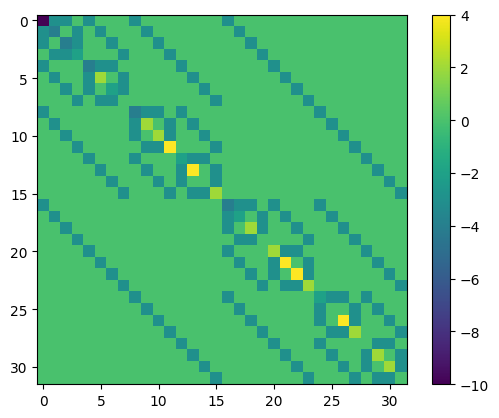

In [53]:
nqubits = 5
h0 = 3
h1 = 1
h = [h0, h1]
hamiltonian = TLFIM(nqubits, h, dense=False)
plt.imshow(np.real(hamiltonian.matrix))
plt.colorbar()

# Train VQE

In [54]:
# build ansatz circuit
nlayer = 1
ansatz_circ = ansatze.hdw_efficient(nqubits, nlayer)
print(ansatz_circ.draw())

[Qibo 0.2.12|WARNING|2024-10-22 12:20:09]: Starting on qibo 0.2.13, ``Circuit.draw`` will work in-place. The in-place method is currently implemented as ``Circuit.display``, but will be renamed as ``Circuit.draw`` on release 0.2.13. In release 0.2.12, the in-place display of circuits is accessible as ``Circuit.display``.


q0: ─RY─RZ─o───RY─RZ───o─RY─
q1: ─RY─RZ─Z───RY─RZ─o─|─RY─
q2: ─RY─RZ───o─RY─RZ─Z─|─RY─
q3: ─RY─RZ───Z─RY─RZ───|─RY─
q4: ─RY─RZ─────RY─RZ───Z─RY─


In [55]:
# build zero state
zero_state = hamiltonian.backend.zero_state(nqubits)
# initial params
params_len = len(ansatz_circ.get_parameters())
# fix numpy seed to ensure replicability of the experiment
seed = 10
np.random.seed(seed)
initial_params = np.random.uniform(-np.pi, np.pi, params_len)
print(initial_params)
# initial energy
c0 = deepcopy(ansatz_circ)
c0.set_parameters(initial_params)
target_energy = np.real(np.min(np.asarray(hamiltonian.eigenvalues())))
print('Target enegry:', target_energy)
print('Initial energy:', exact_expectation_boost(hamiltonian, c0))

[ 1.70475788 -3.01120431  0.83973663  1.5632809  -0.00938072 -1.72915367
 -1.89712697  1.63696274 -2.07903793 -2.58653723  1.16465009  2.84875441
 -3.11678496  0.07660625  1.96425543  0.70702213  1.39332975 -1.30768123
  2.62495223  1.34821941  0.26731415 -2.2483119  -0.79582348  1.09411377
 -0.36547294]
Target enegry: -16.974668492500406
Initial energy: tf.Tensor(-0.479242827486222, shape=(), dtype=float64)


In [56]:
niter = 1
# define the qibo loss function
objective_boost = partial(vqe_loss)
# logging hisotry
params_history, loss_history, grads_history, fluctuations = [], [], [], []
# set optimizer
optimizer = 'sgd'
tol = 1e-2

In [57]:
# train vqe
(
    partial_results,
    partial_params_history,
    partial_loss_history,
    partial_grads_history,
    partial_fluctuations,
    vqe,
) = train_vqe(
    deepcopy(ansatz_circ),
    hamiltonian,  # Fixed hamiltonian
    optimizer,
    initial_params,
    tol=tol,
    niterations=1,
    nmessage=1,
    loss=objective_boost,
    training_options={'nepochs':100,}
)
params_history = np.array(partial_params_history)
loss_history = np.array(partial_loss_history)
grads_history = np.array(partial_grads_history)
fluctuations = np.array(partial_fluctuations)

INFO:root:Optimization iteration 0/1
INFO:root:Loss -0.47924
INFO:root:Minimize the energy
INFO:root:Optimization iteration 1/1
INFO:root:Loss -0.50334
INFO:root:Optimization iteration 2/1
INFO:root:Loss -0.52075
[Qibo 0.2.12|INFO|2024-10-22 12:20:10]: ite 1 : loss -0.503343
INFO:qibo.config:ite 1 : loss -0.503343
INFO:root:Optimization iteration 3/1
INFO:root:Loss -0.53509
INFO:root:Optimization iteration 4/1
INFO:root:Loss -0.54757
INFO:root:Optimization iteration 5/1
INFO:root:Loss -0.55877
INFO:root:Optimization iteration 6/1
INFO:root:Loss -0.56901
INFO:root:Optimization iteration 7/1
INFO:root:Loss -0.5785
INFO:root:Optimization iteration 8/1
INFO:root:Loss -0.58739
INFO:root:Optimization iteration 9/1
INFO:root:Loss -0.59579
INFO:root:Optimization iteration 10/1
INFO:root:Loss -0.60376
INFO:root:Optimization iteration 11/1
INFO:root:Loss -0.61136
INFO:root:Optimization iteration 12/1
INFO:root:Loss -0.61864
INFO:root:Optimization iteration 13/1
INFO:root:Loss -0.62564
INFO:root:

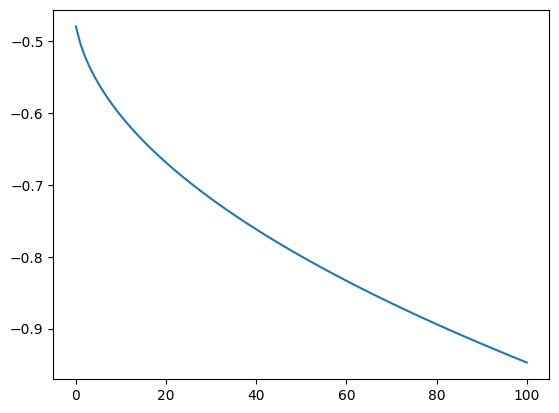

In [58]:
plt.plot(loss_history)

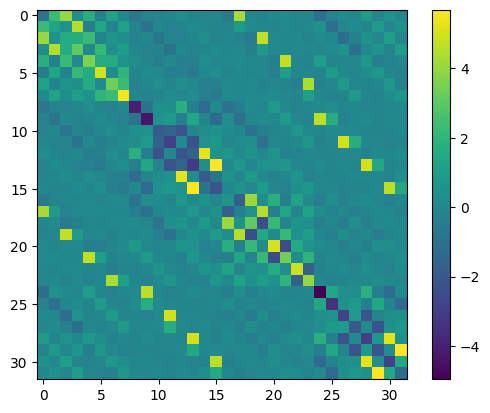

In [59]:
# obtain rotated hamiltonian
new_ham_matrix = rotate_h_with_vqe(hamiltonian=hamiltonian, vqe=vqe)
new_ham = hamiltonians.Hamiltonian(
                nqubits, matrix=new_ham_matrix
            )
plt.imshow(np.real(new_ham.matrix))
plt.colorbar()

In [80]:
# the final circuit
c1 = deepcopy(ansatz_circ)
c1.set_parameters(params_history[-1])

# Train DBI

In [87]:
qibo.set_backend('qibojit')

[Qibo 0.2.12|INFO|2024-10-22 12:47:10]: Using qibojit (numba) backend on /CPU:0
INFO:qibo.config:Using qibojit (numba) backend on /CPU:0


In [88]:
# store past hamiltonian history
ham_hist = [hamiltonian.matrix]
ham_hist.extend(new_ham_matrix)

In [89]:
# initialize DBI
dbi = DoubleBracketIteration(
    hamiltonian=new_ham,
    mode=DoubleBracketGeneratorType.single_commutator,
)

zero_state_t = np.transpose([zero_state])
energy_h0 = float(dbi.h.expectation(np.array(zero_state_t)))
fluctuations_h0 = float(dbi.h.energy_fluctuation(zero_state_t))

print(energy_h0)
print(fluctuations_h0)

-9.326820488419472
2.594351077827698


In [90]:
# define dbi parameters
dbi_steps = 1
d_type = MagneticFieldEvolutionOracle
method = "annealing"

In [91]:
# apply DBI
(
    dbi_hamiltonians,
    dbi_energies,
    dbi_fluctuations,
    dbi_steps,
    dbi_d_matrix,
    dbi_operators,
) = apply_dbi_steps(
    dbi=dbi, d_type = None, nsteps=dbi_steps, method=method,
)

INFO:root:Applying 1 steps of DBI to the given hamiltonian.
INFO:root:step 1
INFO:root:
H matrix: [[-7.88458819-6.10622664e-16j -0.14048774+3.26475167e-02j
  -0.38312998-9.93715826e-02j ...  0.11599452-5.45125938e-01j
   0.50620403+1.24351157e+00j  0.23339873-8.45798786e-02j]
 [-0.14048774-3.26475167e-02j -0.89377843-2.32452946e-16j
  -0.10911267+3.55704094e-02j ...  0.09869885-2.88956391e-02j
  -0.18422258-2.49947857e-03j -0.3169739 +1.58108938e-01j]
 [-0.38312998+9.93715826e-02j -0.10911267-3.55704094e-02j
   2.8611027 +1.73472348e-16j ...  0.14910953+3.09393879e-01j
  -0.06100197-1.66688110e-01j -0.5923307 +2.16230524e-01j]
 ...
 [ 0.11599452+5.45125938e-01j  0.09869885+2.88956391e-02j
   0.14910953-3.09393879e-01j ... -7.59875522-8.32667268e-17j
  -1.30796509+3.07541861e-01j  1.24364271+4.96324719e-01j]
 [ 0.50620403-1.24351157e+00j -0.18422258+2.49947857e-03j
  -0.06100197+1.66688110e-01j ... -1.30796509-3.07541861e-01j
  -5.46757843+3.33066907e-16j  0.13734878+5.40705169e-02j]
 [

In [92]:
ham_hist.extend(dbi_hamiltonians)
dbi_energies_ls = [energy.numpy() for energy in dbi_energies]
dbi_fluctuations.insert(0, fluctuations_h0)
dbi_energies_ls.insert(0, energy_h0)
print(dbi_energies_ls)

[-9.326820488419472, -7.884588187703136]


In [93]:
# update the circuit appending the DBI generator
# and the old circuit with non trainable circuit
circ = deepcopy(c1)
vqe_circ_matrix = c1.unitary()
dbi_operators = [
    new_ham.backend.cast(np.matrix(new_ham.backend.to_numpy(operator)))
    for operator in dbi_operators
]
for gate in reversed([vqe_circ_matrix] + dbi_operators):
    print(gate)
    circ.add(gates.Unitary(gate, *range(circ.nqubits), trainable=False))

tf.Tensor(
[[ 9.29333674e-01+3.41746708e-04j -2.81564046e-02+4.80481528e-03j
   2.63540414e-02-4.59953775e-03j ... -1.77409981e-02+5.14881958e-02j
  -5.16467808e-03-6.00032659e-02j -2.76677179e-02+4.90888841e-03j]
 [ 2.48289278e-02+8.69725364e-03j  9.96419526e-01-4.18932625e-05j
  -1.23346571e-03+9.44180059e-04j ... -5.75863083e-03-9.08618382e-04j
   4.82290859e-03+2.34517454e-03j -1.97751840e-02+1.02096418e-02j]
 [-4.44592619e-02-7.97501725e-03j  3.31114934e-04-9.67083018e-04j
   9.78765417e-01+2.52270019e-03j ... -2.53972786e-03+2.70853898e-02j
  -1.18845299e-03-3.00845831e-02j -1.14659034e-02+6.65578235e-03j]
 ...
 [-1.41575938e-02-4.78889799e-02j  7.31219553e-03-5.02686237e-03j
   1.16055849e-03+2.07706763e-02j ...  9.02266087e-01-2.25231484e-03j
   2.41705849e-02-2.29219718e-02j -1.09483319e-01-4.36801488e-02j]
 [-2.66760387e-02+6.68858673e-02j -8.78323890e-03+2.88761424e-03j
  -7.32040060e-03-1.49319769e-02j ...  6.30344208e-02+1.83688579e-02j
   9.18433392e-01-6.40354427e-04j -2

In [94]:
c_qasm = models.Circuit.to_qasm(circ)
c_tket = pytket.qasm.circuit_from_qasm_str(c_qasm)
render_circuit_jupyter(c_tket)

[Qibo 0.2.12|ERROR|2024-10-22 12:47:11]: Unitary is not supported by OpenQASM
ERROR:qibo.config:Unitary is not supported by OpenQASM


NotImplementedError: Unitary is not supported by OpenQASM